# A Brazil Climate Estimate Cluster Analysis from 10-yr of INMET spatio-temporal data

*Marcos Conceição*, 2020

This notebook estimates Brazil climate types from 10 years of hourly measures from 561 meteorological stations. The original dataset station time series per year were downloaded from Instituto Nacional de Meteorologia (INMET) portal at [Dados Históricos - INMET](https://portal.inmet.gov.br/dadoshistoricos).

The series were compiled into a new dataset, with mean temperature, humidity, precipitation, pressure, and wind speed, as well as their dispersion (standard deviation metric was used) in a year. All these variables are given along with station coordinates, state and Brazil region on each row.

The motivation of this notebook is comparing climate clusters calculated from these dataset to Peel, *et. al.* (2007) results in their article: *Updated world map of the Koppen-Geiger climate classification*.

## Contents:

1. Dataset integrity check;
2. Recovery of missing data (weighted KNN regression);
3. Data visualization (weighted KNN regression interpolation);
4. Principal component analysis of numeric columns;
5. K-means cluster analysis (elbow and silhouette methods in the original and principal components domain);
6. Cluster analysis and characterization (weighted KNN classification);
7. Drawing schematic variable maps (weighted KNN classification);
8. Misc.: trying to use region categorical data;

## Importing libraries

In [514]:
from os import listdir
from os.path import join, basename
from datetime import datetime, date, time, timedelta
from io import StringIO
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mplticker
import cartopy.crs as crs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.vectorized import contains
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import silhouette_samples, silhouette_score
sns.set_context('paper')
plt.style.use('seaborn-dark')
mpl.rc('image', cmap='viridis')
abc = [chr(i) for i in range(97,123)]
ABC = [i.upper() for i in abc]

## Opening data

In [516]:
odf = pd.read_csv('inmet_2009_2019_yearly.csv')
odf.head()

,lat,lon,region,state,station,H,P,R,T,V,sH,sP,sR,sT,sV
0,-15.789444,-47.925833,NE,RN,SANTA CRUZ,65.450729,887.287915,113.008965,21.527390,2.324405,16.636954,2.060525,56.675536,3.434736,1.117212
1,-15.599722,-48.131111,NE,BA,BARREIRAS,63.415417,888.740947,131.155556,21.908385,2.318807,15.382483,1.644735,44.732468,3.314155,1.329252
2,-15.939167,-50.141389,SE,SP,ARIRANHA,62.718272,954.701575,111.373788,25.655920,1.086215,16.226072,1.781967,69.084993,4.065550,1.061130
3,-3.103333,-60.016389,S,RS,BAGE,74.779010,1004.262176,167.319125,27.768980,1.452776,13.432962,2.381811,69.886715,2.598391,0.799783
4,-6.650278,-69.866944,S,PR,VENTANIA,70.680097,997.946723,185.486389,25.537133,0.782401,13.597679,2.583953,77.443203,3.126108,0.804853


In [262]:
odf.describe().T

,count,mean,std,min,25%,50%,75%,max
lat,561.0,-15.563160,8.301153,-33.741667,-22.235278,-15.935278,-8.666389,4.477500
lon,561.0,-48.173564,7.358577,-72.786667,-52.601111,-48.131111,-42.677222,-29.316667
H,561.0,72.265137,7.939112,49.935607,67.231196,72.696740,78.343855,90.559963
P,561.0,967.169377,37.722145,763.268354,943.495954,973.575495,998.794695,1016.121159
R,561.0,102.945187,41.417317,4.500000,76.619646,101.207163,127.616667,267.916667
T,561.0,23.646605,3.230790,10.703426,21.689522,24.229970,26.198640,30.865950
V,561.0,1.996727,0.951947,0.110801,1.343852,1.857584,2.521674,7.096284
sH,561.0,15.483323,2.558783,4.706832,14.311998,16.090670,17.085667,20.625819
sP,561.0,2.376282,1.138982,1.254278,1.801416,2.066448,2.646520,14.873817
sR,555.0,65.429450,20.821090,1.944544,52.339593,64.542666,77.467709,175.008928


## Checking for NaNs and infinte values

In [263]:
# column groups:
coord_cols = ['lon', 'lat']
dsc_cols = ['region', 'state', 'station']
cat_cols = ['NE', 'N', 'CO', 'S', 'SE']
num_cols = [c for c in odf.columns if c not in (lat_lon+dsc_cols+cat_cols)]
num_cols

['H', 'P', 'R', 'T', 'V', 'sH', 'sP', 'sR', 'sT', 'sV']

In [264]:
null_mask = odf.isnull().T.any()
n_null = null_mask.sum()
print(f"Number of rows with null values: {n_null} ({n_null/odf.shape[0]:.0%}).")

Number of rows with null values: 6 (1%).


In [265]:
odf[null_mask]

,lat,lon,region,state,station,H,P,R,T,V,sH,sP,sR,sT,sV
25,-4.250556,-69.935000,N,PA,MARABA,74.939670,1002.812203,12.000000,25.435670,0.419304,12.604709,2.320246,NaN,3.895292,0.662865
26,-4.530000,-71.617500,NE,PB,SAO GONCALO,88.724039,1000.832506,208.100000,25.919704,0.474727,13.882481,2.110240,NaN,3.072027,0.677580
28,-0.414444,-65.017500,CO,MT,CAMPO NOVO DOS PARECIS,78.281039,1006.630500,99.142857,26.235277,0.110801,13.027858,1.907361,NaN,3.222528,0.394585
125,-2.700000,-44.850000,SE,MG,AIMORES,84.654529,1009.107984,133.000000,26.512966,0.703665,11.308528,1.577510,NaN,2.694260,0.931435
227,-12.430000,-64.420000,SE,SP,PIRACICABA,65.002010,997.499012,23.750000,25.161809,1.370702,17.065660,2.428062,NaN,4.685472,1.091545
343,3.358889,-59.823889,CO,GO,JATAI,69.594292,1001.142434,136.250000,27.462531,2.466772,12.884847,1.810201,NaN,2.725816,1.167248


Data is missing in the **sR** column (yearly standard deviation of monthly precipitation).

In [266]:
inf_mask = ~np.isfinite(odf[num_cols]).T.any()
n_inf = inf_mask.sum()
print(f"Number of rows with infinite values: {n_inf} ({n_inf/odf.shape[0]:.0%}).")

Number of rows with infinite values: 0 (0%).


In [267]:
odf[inf_mask]

,lat,lon,region,state,station,H,P,R,T,V,sH,sP,sR,sT,sV


No infinite values.

## Interpolating missing data

In [268]:
odf[null_mask]

,lat,lon,region,state,station,H,P,R,T,V,sH,sP,sR,sT,sV
25,-4.250556,-69.935000,N,PA,MARABA,74.939670,1002.812203,12.000000,25.435670,0.419304,12.604709,2.320246,NaN,3.895292,0.662865
26,-4.530000,-71.617500,NE,PB,SAO GONCALO,88.724039,1000.832506,208.100000,25.919704,0.474727,13.882481,2.110240,NaN,3.072027,0.677580
28,-0.414444,-65.017500,CO,MT,CAMPO NOVO DOS PARECIS,78.281039,1006.630500,99.142857,26.235277,0.110801,13.027858,1.907361,NaN,3.222528,0.394585
125,-2.700000,-44.850000,SE,MG,AIMORES,84.654529,1009.107984,133.000000,26.512966,0.703665,11.308528,1.577510,NaN,2.694260,0.931435
227,-12.430000,-64.420000,SE,SP,PIRACICABA,65.002010,997.499012,23.750000,25.161809,1.370702,17.065660,2.428062,NaN,4.685472,1.091545
343,3.358889,-59.823889,CO,GO,JATAI,69.594292,1001.142434,136.250000,27.462531,2.466772,12.884847,1.810201,NaN,2.725816,1.167248


We must interpolate missing data via regression. We will use weighted KNN for this. Our inputs will be coordinates and all other variables, while our outputs will be precipitation standard deviation.

### Weighted KNN for data interpolation

In [269]:
input_cols = [c for c in coord_cols+num_cols if c != 'sR']

In [270]:
X = odf[~null_mask][input_cols]
y = odf[~null_mask]['sR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4)

In [271]:
knn = KNeighborsRegressor(9, weights='distance')
knn.fit(X_train, y_train)

ŷ_test = knn.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, ŷ_test))
relerr = rmse/y_test.mean()
print(f'RMSE = {rmse} ({relerr:.2%})')

RMSE = 11.467757546248682 (17.81%)


In [272]:
X_null = odf[null_mask][input_cols]
ŷ_null = knn.predict(X_null)

print('Regression values for sR:')
print(*ŷ_null, sep='\n')

Regression values for sR:
27.42360601162177
91.80061136340235
76.09608449329014
79.06089264282271
29.067267876921477
68.9678156447285


Now we will replace the NaNs in odf to create our modified dataframe, df:

In [273]:
odf[null_mask]

,lat,lon,region,state,station,H,P,R,T,V,sH,sP,sR,sT,sV
25,-4.250556,-69.935000,N,PA,MARABA,74.939670,1002.812203,12.000000,25.435670,0.419304,12.604709,2.320246,NaN,3.895292,0.662865
26,-4.530000,-71.617500,NE,PB,SAO GONCALO,88.724039,1000.832506,208.100000,25.919704,0.474727,13.882481,2.110240,NaN,3.072027,0.677580
28,-0.414444,-65.017500,CO,MT,CAMPO NOVO DOS PARECIS,78.281039,1006.630500,99.142857,26.235277,0.110801,13.027858,1.907361,NaN,3.222528,0.394585
125,-2.700000,-44.850000,SE,MG,AIMORES,84.654529,1009.107984,133.000000,26.512966,0.703665,11.308528,1.577510,NaN,2.694260,0.931435
227,-12.430000,-64.420000,SE,SP,PIRACICABA,65.002010,997.499012,23.750000,25.161809,1.370702,17.065660,2.428062,NaN,4.685472,1.091545
343,3.358889,-59.823889,CO,GO,JATAI,69.594292,1001.142434,136.250000,27.462531,2.466772,12.884847,1.810201,NaN,2.725816,1.167248


In [274]:
df = odf.copy()
df.loc[null_mask, 'sR'] = ŷ_null
df[null_mask]

,lat,lon,region,state,station,H,P,R,T,V,sH,sP,sR,sT,sV
25,-4.250556,-69.935000,N,PA,MARABA,74.939670,1002.812203,12.000000,25.435670,0.419304,12.604709,2.320246,27.423606,3.895292,0.662865
26,-4.530000,-71.617500,NE,PB,SAO GONCALO,88.724039,1000.832506,208.100000,25.919704,0.474727,13.882481,2.110240,91.800611,3.072027,0.677580
28,-0.414444,-65.017500,CO,MT,CAMPO NOVO DOS PARECIS,78.281039,1006.630500,99.142857,26.235277,0.110801,13.027858,1.907361,76.096084,3.222528,0.394585
125,-2.700000,-44.850000,SE,MG,AIMORES,84.654529,1009.107984,133.000000,26.512966,0.703665,11.308528,1.577510,79.060893,2.694260,0.931435
227,-12.430000,-64.420000,SE,SP,PIRACICABA,65.002010,997.499012,23.750000,25.161809,1.370702,17.065660,2.428062,29.067268,4.685472,1.091545
343,3.358889,-59.823889,CO,GO,JATAI,69.594292,1001.142434,136.250000,27.462531,2.466772,12.884847,1.810201,68.967816,2.725816,1.167248


Checking again for missing data yields:

In [275]:
null_mask = df.isnull().T.any()
n_null = null_mask.sum()
print(f"Number of rows with null values: {n_null} ({n_null/df.shape[0]:.0%}).")

Number of rows with null values: 0 (0%).


## Plotting stations

In [276]:
brazil_shape_file = "/mnt/hdd/home/tmp/fisica_meio_ambiente/gadm36_BRA_shp/gadm36_BRA_0.shp"
states_shape_file = "/mnt/hdd/home/tmp/fisica_meio_ambiente/gadm36_BRA_shp/gadm36_BRA_1.shp"
brazil_shapes = list(shpreader.Reader(brazil_shape_file).geometries())
states_shapes = list(shpreader.Reader(states_shape_file).geometries())

In [277]:
projection = crs.PlateCarree()

In [278]:
all_extents = {}
all_extents['left'] = -75
all_extents['right'] = -27
all_extents['bottom'] = -35
all_extents['top'] = 6
all_extents_tuple = [all_extents[d] for d in ['left', 'right', 'bottom', 'top']]
all_extents

{'left': -75, 'right': -27, 'bottom': -35, 'top': 6}

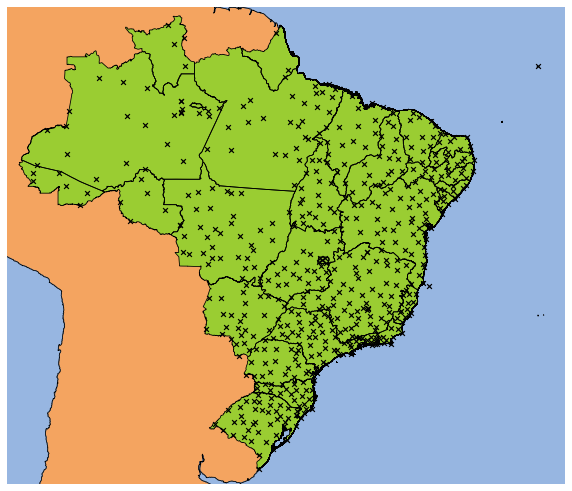

In [279]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, projection=projection)
ax.coastlines(resolution='10m')

ax.add_feature(cfeature.LAND, fc='sandybrown', ec='black')
ax.add_feature(cfeature.OCEAN)
ax.add_geometries(brazil_shapes, projection, ec='none', fc='yellowgreen')
ax.add_geometries(states_shapes, projection, ec='black', fc='none')
ax.scatter(df['lon'], df['lat'], marker='x', c='black', zorder=np.inf)

ax.set_extent(all_extents_tuple, crs.PlateCarree())

ax.grid()

CAICO station: São Pedro e São Paulo Archipelago.

## Dummifying region columns

In [280]:
df = pd.get_dummies(df, columns=['region'], prefix='', prefix_sep='', )
df.reset_index(drop=True, inplace=True)
df.head()

,lat,lon,state,station,H,P,R,T,V,sH,sP,sR,sT,sV,CO,N,NE,S,SE
0,-15.789444,-47.925833,RN,SANTA CRUZ,65.450729,887.287915,113.008965,21.527390,2.324405,16.636954,2.060525,56.675536,3.434736,1.117212,0,0,1,0,0
1,-15.599722,-48.131111,BA,BARREIRAS,63.415417,888.740947,131.155556,21.908385,2.318807,15.382483,1.644735,44.732468,3.314155,1.329252,0,0,1,0,0
2,-15.939167,-50.141389,SP,ARIRANHA,62.718272,954.701575,111.373788,25.655920,1.086215,16.226072,1.781967,69.084993,4.065550,1.061130,0,0,0,0,1
3,-3.103333,-60.016389,RS,BAGE,74.779010,1004.262176,167.319125,27.768980,1.452776,13.432962,2.381811,69.886715,2.598391,0.799783,0,0,0,1,0
4,-6.650278,-69.866944,PR,VENTANIA,70.680097,997.946723,185.486389,25.537133,0.782401,13.597679,2.583953,77.443203,3.126108,0.804853,0,0,0,1,0


In [281]:
coord_cols = ['lon', 'lat']
dsc_cols = ['state', 'station']
cat_cols = ['NE', 'N', 'CO', 'S', 'SE']
num_cols = [c for c in df.columns if c not in (lat_lon+dsc_cols+cat_cols)]

In [282]:
coords = df[lat_lon]
X_num = df[num_cols]
X_cat = df[cat_cols]

X_num.head()

,H,P,R,T,V,sH,sP,sR,sT,sV
0,65.450729,887.287915,113.008965,21.527390,2.324405,16.636954,2.060525,56.675536,3.434736,1.117212
1,63.415417,888.740947,131.155556,21.908385,2.318807,15.382483,1.644735,44.732468,3.314155,1.329252
2,62.718272,954.701575,111.373788,25.655920,1.086215,16.226072,1.781967,69.084993,4.065550,1.061130
3,74.779010,1004.262176,167.319125,27.768980,1.452776,13.432962,2.381811,69.886715,2.598391,0.799783
4,70.680097,997.946723,185.486389,25.537133,0.782401,13.597679,2.583953,77.443203,3.126108,0.804853


In [283]:
scaler = StandardScaler()
X_num_sc = scaler.fit_transform(X_num)
X_num_sc = pd.DataFrame(X_num_sc, columns=X_num.columns)
X_num_sc.head()

,H,P,R,T,V,sH,sP,sR,sT,sV
0,-0.859100,-2.119518,0.243202,-0.656529,0.344526,0.451254,-0.277475,-0.418074,-0.399973,-0.314016
1,-1.115694,-2.080964,0.681733,-0.538497,0.338640,-0.039444,-0.642855,-0.990809,-0.562896,0.259466
2,-1.203584,-0.330812,0.203686,0.622482,-0.957326,0.290533,-0.522261,0.177027,0.452350,-0.465696
3,0.316927,0.984194,1.555663,1.277104,-0.571918,-0.802018,0.004858,0.215473,-1.530000,-1.172534
4,-0.199828,0.816624,1.994694,0.585682,-1.276761,-0.737588,0.182493,0.577848,-0.816975,-1.158821


In [284]:
X_num_sc

,H,P,R,T,V,sH,sP,sR,sT,sV
0,-0.859100,-2.119518,0.243202,-0.656529,0.344526,0.451254,-0.277475,-0.418074,-0.399973,-0.314016
1,-1.115694,-2.080964,0.681733,-0.538497,0.338640,-0.039444,-0.642855,-0.990809,-0.562896,0.259466
2,-1.203584,-0.330812,0.203686,0.622482,-0.957326,0.290533,-0.522261,0.177027,0.452350,-0.465696
3,0.316927,0.984194,1.555663,1.277104,-0.571918,-0.802018,0.004858,0.215473,-1.530000,-1.172534
4,-0.199828,0.816624,1.994694,0.585682,-1.276761,-0.737588,0.182493,0.577848,-0.816975,-1.158821
...,...,...,...,...,...,...,...,...,...,...
556,1.268879,0.537686,1.878261,0.605842,-1.092457,-0.743612,-0.129558,0.019685,-0.826425,-1.065737
557,1.273288,0.535748,0.439134,0.580666,-0.658392,-0.696672,-0.083038,2.096679,-0.620182,-0.911984
558,0.511917,0.444931,0.090893,0.579791,-0.508183,-0.910329,-0.128260,0.614093,-0.487119,-0.690716
559,1.488055,0.682439,1.542413,0.537639,-0.623750,-0.913525,-0.129164,0.998415,-0.596789,-0.743686


## Looking at variables

In [285]:
extents = {}
extents['left'] = -75
extents['right'] = -31
extents['bottom'] = -35
extents['top'] = 6
extents_tuple = [extents[d] for d in ['left', 'right', 'bottom', 'top']]
extents

{'left': -75, 'right': -31, 'bottom': -35, 'top': 6}

In [286]:
variables = ['T', 'H', 'P', 'R', 'V']
stds = ['s' + c for c in variables]

T, H, P, R, V = [df[[c for c in df.columns if c.startswith(var)]].mean(axis=1)
                 for var in variables]
sT, sH, sP, sR, sV = [df[[c for c in df.columns if c.startswith(var)]].mean(axis=1)
                      for var in stds]

In [507]:
def knn_map(coords, labels, extents=None, div=None,
            k=6, weighted=True,
            cmap=None, n_cmap=None, vmin=None, vmax=None,
            scat_coords=True, marker='o', ms=11, mec='black', mfc='black',
            title=None, cbar_label=None,
            projection=crs.PlateCarree(),
            fig=None, ax=None, figsize=(8,8),
            add_cbar=True, label_names=None):
    
    def get_n_lon_lat(div):
        if div is None:
            n_lon = n_lat = 200
        elif isinstance(div, int):
            n_lon = n_lat = div
        else:
            n_lon, n_lat = div
        return n_lon, n_lat
    
    def get_extents(extents):
        if isinstance(extents, dict):
            pass
        elif extents is None:
            extents = {'left':-180, 'right':180, 'bottom':-90, 'top':90}
        else:
            extents = {lim: extents[i] for i, lim in
                       enumerate(['left', 'right', 'bottom', 'top'])}
        return extents
    
    coords = np.asarray(coords)
    labels = np.asarray(labels)
    extents = get_extents(extents)
    extents_tuple = [extents[lim] for lim in ['left', 'right', 'bottom', 'top']]
    n_lon, n_lat = get_n_lon_lat(div)
    
    lon_int_ax = np.linspace(extents['left'], extents['right'], n_lon)
    lat_int_ax = np.linspace(extents['bottom'], extents['top'], n_lat)
    lon_int_grid, lat_int_grid = np.meshgrid(lon_int_ax, lat_int_ax)
    coords_int = np.stack([arr.ravel()
                           for arr in (lon_int_grid, lat_int_grid)],
                          axis=1)

    weights = 'distance' if weighted else 'uniform'
    try:
        knn = KNeighborsClassifier(n_neighbors=k, weights=weights)
        knn.fit(coords, labels)
        n_classes = knn.classes_.size
        cmap = mpl.cm.get_cmap(cmap, n_classes)
    except ValueError:
        knn = KNeighborsRegressor(n_neighbors=k, weights=weights)
        knn.fit(coords, labels)
        n_classes = None
        cmap = mpl.cm.get_cmap(cmap, n_cmap)
         
    labels_int = knn.predict(coords_int)
    
    mask = ~contains(brazil_shapes[0],
                     coords_int[:,0],
                     coords_int[:,1])
    
    masked = np.ma.masked_array(labels_int, mask)
    masked_grid = masked.reshape((n_lon, n_lat))

    if ax is None:
        if fig is None:
            fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=projection)

    ax.add_feature(cfeature.OCEAN, zorder=0)
    ax.add_feature(cfeature.LAND, zorder=1, fc='sandybrown', ec='black')
    ax.add_geometries(states_shapes, projection, zorder=3, fc='none', ec='black')
    
    pcol = ax.pcolormesh(lon_int_grid, lat_int_grid, masked_grid,
                         zorder=2, cmap=cmap, vmin=vmin, vmax=vmax)
    
    if add_cbar:
        if n_classes is not None:
            boundaries = np.arange(0, n_classes+1)
            values = boundaries[:-1]
            ticks = values + 0.5
            cbar = plt.colorbar(pcol,
                                ax=ax,
                                boundaries=boundaries,
                                orientation='horizontal',
                                values=values,
                                ticks=boundaries)
            cbar.set_ticks(ticks)
            if label_names:
                cbar.set_ticklabels(label_names)
            else:
                cbar.set_ticklabels(knn.classes_)
        else:
            cbar = plt.colorbar(pcol, ax=ax, orientation='horizontal')

        if cbar_label is not None:
            cbar.set_label(cbar_label)
    if title is not None:
        ax.set_title(title)
    if scat_coords:
        if n_classes is not None:
            for c in knn.classes_:
                c_idx = labels==c
                ax.scatter(coords[c_idx,0], coords[c_idx,1], zorder=4,
                           marker=marker, s=ms, alpha=.4,
                           ec=mec, fc=cmap(c/n_classes))
        else:
            ax.scatter(coords[:,0], coords[:,1], zorder=4,
                       marker=marker, s=ms, alpha=.4,
                       ec=mec, fc=mfc)
    ax.set_extent(extents_tuple, projection)
    
    gl = ax.gridlines(crs=projection, draw_labels=True,
                      linewidth=1, color='white', alpha=.2, linestyle='--')

### Creating a good colormap for pressure 

In [397]:
# low pressure <--> clouds; high pressure <--> open sky
# low pressure <--> greys; high pressure <--> blues
N = 200
blues = mpl.cm.Blues(np.linspace(0,1, N))
greys_r = mpl.cm.Greys_r(np.linspace(0,1, N))
grey_blue = np.concatenate([greys_r, blues])
grey_blue = mpl.colors.ListedColormap(grey_blue)

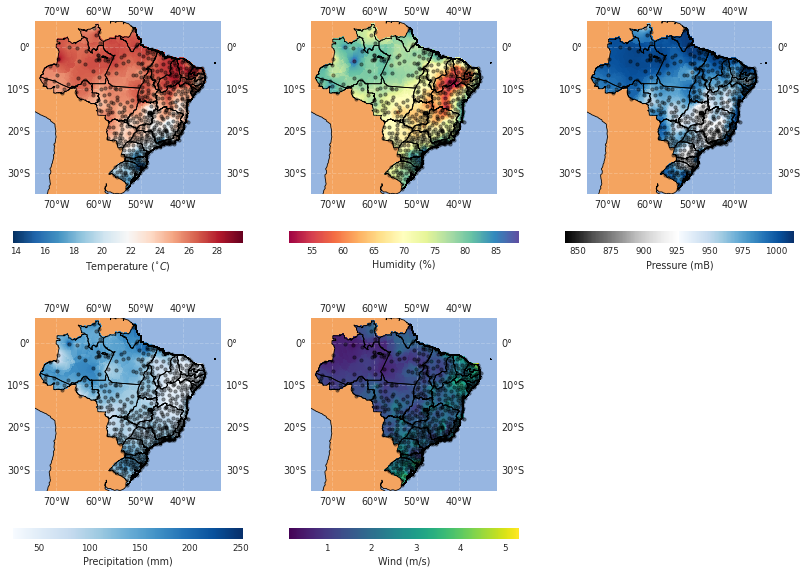

In [398]:
fig, axes = plt.subplots(2, 3, figsize=(14,10), subplot_kw={'projection':projection})

knn_map(coords, T, extents, ax=axes.flat[0], cbar_label=r'Temperature ($^{\circ}C$)', cmap='RdBu_r')
knn_map(coords, H, extents, ax=axes.flat[1], cbar_label=r'Humidity (%)', cmap='Spectral')
knn_map(coords, P, extents, ax=axes.flat[2], cbar_label=r'Pressure (mB)', cmap=grey_blue)
knn_map(coords, R, extents, ax=axes.flat[3], cbar_label=r'Precipitation (mm)', cmap='Blues')
knn_map(coords, V, extents, ax=axes.flat[4], cbar_label=r'Wind (m/s)', cmap='viridis')
axes.flat[-1].remove()

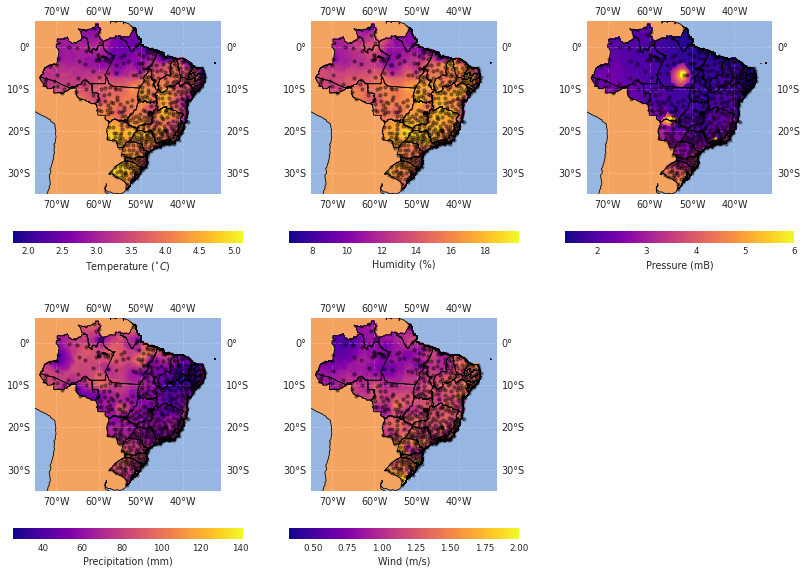

In [399]:
fig, axes = plt.subplots(2,3, figsize=(14,10), subplot_kw={'projection':projection})
scmap = 'plasma'
knn_map(coords, sT, extents, ax=axes.flat[0], cbar_label=r'Temperature ($^{\circ}C$)', cmap=scmap)
knn_map(coords, sH, extents, ax=axes.flat[1], cbar_label=r'Humidity (%)', cmap=scmap)
knn_map(coords, sP, extents, ax=axes.flat[2], cbar_label=r'Pressure (mB)', cmap=scmap, vmax=6)
knn_map(coords, sR, extents, ax=axes.flat[3], cbar_label=r'Precipitation (mm)', cmap=scmap)
knn_map(coords, sV, extents, ax=axes.flat[4], cbar_label=r'Wind (m/s)', cmap=scmap, vmax=2)
axes.flat[-1].remove()

In [310]:
df[df['sP']>6]

,lat,lon,state,station,H,P,R,T,V,sH,sP,sR,sT,sV,CO,N,NE,S,SE
198,-6.639722,-51.956944,MT,SAO FELIX DO ARAGUAIA,78.815797,987.867897,150.508333,26.198640,1.588278,15.884453,12.501164,63.103013,3.499945,1.064278,1,0,0,0,0
364,-22.373889,-44.703056,MS,COXIM,82.125538,763.268354,142.672222,10.703426,2.847170,16.117948,14.873817,78.407102,3.436498,1.593999,1,0,0,0,0
547,-17.297222,-54.837222,RS,SANTA ROSA,69.673177,945.576353,93.764280,24.352213,1.771318,15.911930,14.622271,58.606179,3.909244,1.286402,0,0,0,1,0


## PCA

In [327]:
pca = PCA()
X_pca_full = pca.fit_transform(X_num_sc)
X_pca_full = pd.DataFrame(X_pca_full, columns=np.arange(1, X_num.columns.size+1))
X_pca_full.head()

,1,2,3,4,5,6,7,8,9,10
0,-0.847106,0.981557,-0.052871,-1.698452,0.598127,1.091698,-0.507021,-0.145552,0.247912,-0.308904
1,-0.873402,0.710085,0.442283,-1.934483,0.516722,1.030901,-1.189185,0.338872,-0.247735,-0.316662
2,-0.673966,-0.644175,-1.163536,-0.506441,-0.688486,0.752904,-0.071223,0.400870,-0.164245,-0.019472
3,2.021792,-1.957614,-0.381864,0.140697,-0.009066,0.539183,-1.066104,-0.219245,0.422579,-0.336370
4,2.036194,-1.260124,-1.246281,0.146786,-0.392069,0.878067,-0.962455,0.153971,-0.233987,-0.584855


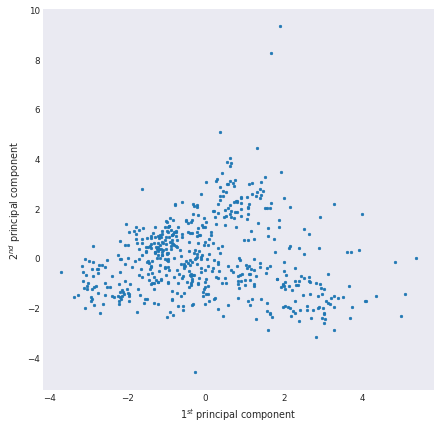

In [328]:
plt.figure(figsize=(7,7))
plt.xlabel('$1^{st}$ principal component')
plt.ylabel('$2^{nd}$ principal component')
plt.scatter(X_pca_full[1], X_pca_full[2], marker='.')

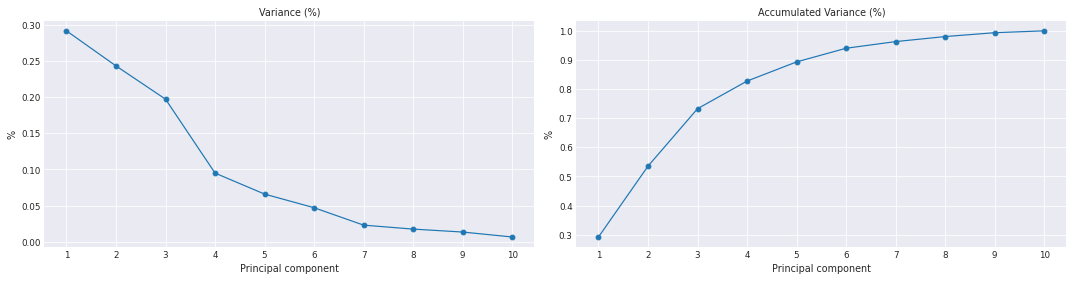

In [329]:
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(X_pca_full.columns, pca.explained_variance_ratio_, marker='o')
plt.xticks(X_pca_full.columns)
plt.title('Variance (%)')
plt.xlabel('Principal component')
plt.ylabel('%')
plt.grid()
plt.subplot(122)
plt.plot(X_pca_full.columns, np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xticks(X_pca_full.columns)
plt.title('Accumulated Variance (%)')
plt.xlabel('Principal component')
plt.ylabel('%')
plt.grid()
plt.tight_layout()

Taking **90% of variance** with **5 components**:

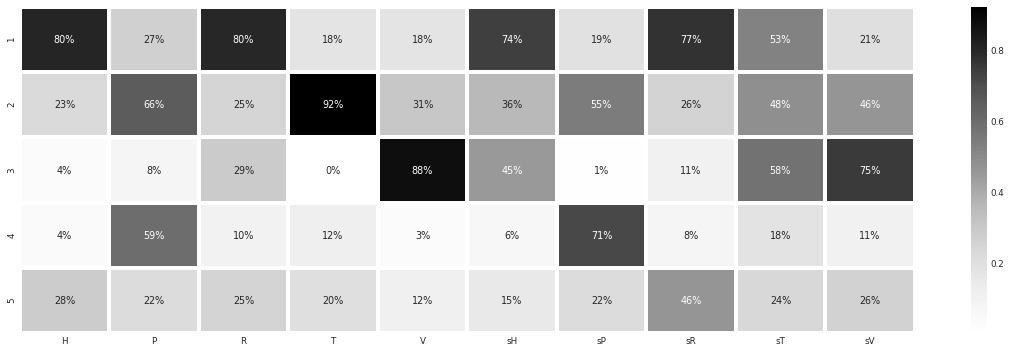

In [330]:
fig,axes = plt.subplots(figsize=(16,5))

n_components = 5

X_all = pd.concat([X_num_sc, X_pca_full], axis=1)
corr = X_all.corr()
abscorr = np.abs(corr)

resp = abscorr.copy()
for i in X_pca_full.columns:
    resp.loc[i,:] /= np.sum(abscorr.loc[i,:])

sns.heatmap(
    abscorr.loc[X_pca_full.columns[:n_components], X_num.columns],
#     resp.loc[X_pca_full.columns[:n_components], X_num.columns],
    annot=True, fmt='.0%',
    cmap='Greys',
    linewidths=3,
)

plt.tight_layout()

In [331]:
X_pca = X_pca_full.loc[:,:5]
X_pca.head()

,1,2,3,4,5
0,-0.847106,0.981557,-0.052871,-1.698452,0.598127
1,-0.873402,0.710085,0.442283,-1.934483,0.516722
2,-0.673966,-0.644175,-1.163536,-0.506441,-0.688486
3,2.021792,-1.957614,-0.381864,0.140697,-0.009066
4,2.036194,-1.260124,-1.246281,0.146786,-0.392069


In [332]:
pca_cols = [*X_pca.columns]
df[pca_cols] = X_pca
df.head()

,lat,lon,state,station,H,P,R,T,V,sH,...,CO,N,NE,S,SE,1,2,3,4,5
0,-15.789444,-47.925833,RN,SANTA CRUZ,65.450729,887.287915,113.008965,21.527390,2.324405,16.636954,...,0,0,1,0,0,-0.847106,0.981557,-0.052871,-1.698452,0.598127
1,-15.599722,-48.131111,BA,BARREIRAS,63.415417,888.740947,131.155556,21.908385,2.318807,15.382483,...,0,0,1,0,0,-0.873402,0.710085,0.442283,-1.934483,0.516722
2,-15.939167,-50.141389,SP,ARIRANHA,62.718272,954.701575,111.373788,25.655920,1.086215,16.226072,...,0,0,0,0,1,-0.673966,-0.644175,-1.163536,-0.506441,-0.688486
3,-3.103333,-60.016389,RS,BAGE,74.779010,1004.262176,167.319125,27.768980,1.452776,13.432962,...,0,0,0,1,0,2.021792,-1.957614,-0.381864,0.140697,-0.009066
4,-6.650278,-69.866944,PR,VENTANIA,70.680097,997.946723,185.486389,25.537133,0.782401,13.597679,...,0,0,0,1,0,2.036194,-1.260124,-1.246281,0.146786,-0.392069


# Cluster Analysis

## KMeans with 3 clusters

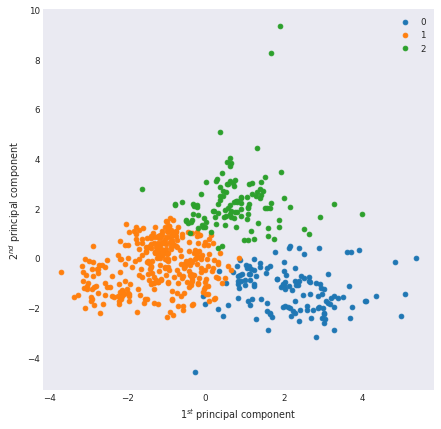

In [338]:
km = KMeans(n_clusters=3)
labels = km.fit_predict(X_num_sc)

colors = [f'C{c}' for c in range(km.n_clusters)]
names = list(range(km.n_clusters))

plt.figure(figsize=(7,7))
plt.xlabel('$1^{st}$ principal component')
plt.ylabel('$2^{nd}$ principal component')
for label, (name, color) in enumerate(zip(names, colors)):
    indices = labels==label
    _X_pca = X_pca_clip[indices]
    plt.scatter(_X_pca.loc[:,1], _X_pca.loc[:,2], c=color,  label=name, marker='o')
plt.legend()

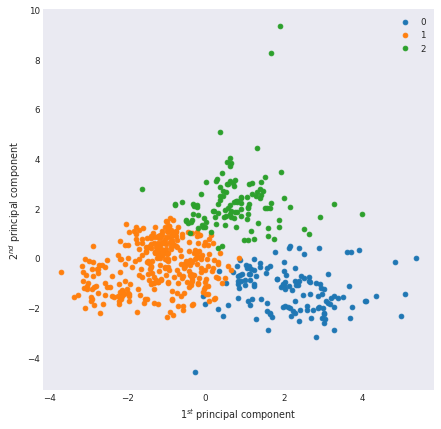

In [339]:
km = KMeans(n_clusters=3)
labels = km.fit_predict(X_pca)

colors = [f'C{c}' for c in range(km.n_clusters)]
names = list(range(km.n_clusters))

plt.figure(figsize=(7,7))
plt.xlabel('$1^{st}$ principal component')
plt.ylabel('$2^{nd}$ principal component')
for label, (name, color) in enumerate(zip(names, colors)):
    indices = labels==label
    _X_pca = X_pca_clip[indices]
    plt.scatter(_X_pca.loc[:,1], _X_pca.loc[:,2], c=color,  label=name, marker='o')
plt.legend()

## Testing for some other values of K

### Original dataset

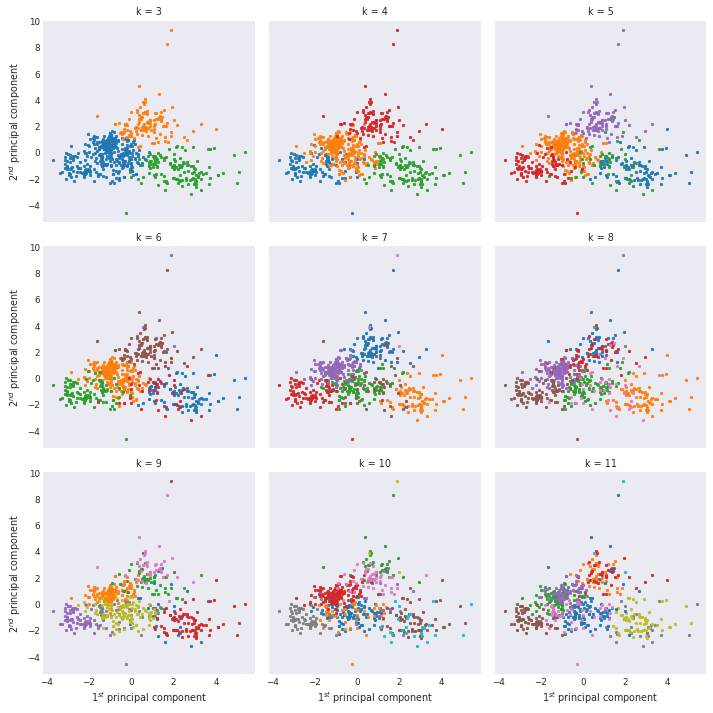

In [343]:
fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for k, ax in enumerate(axes.flat, start=3):
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X_num_sc)
    for label in range(k):
        indices = labels==label
        _X_pca = X_pca_clip[indices]
        ax.scatter(_X_pca.loc[:,1], _X_pca.loc[:,2],
                   c=f"C{label}", label=name, marker='.')
    ax.set_title(f'k = {k}')
    
for i in range(3):
    axes[2,i].set_xlabel('$1^{st}$ principal component')
    axes[i,0].set_ylabel('$2^{nd}$ principal component')
    
plt.tight_layout()

### PCA domain

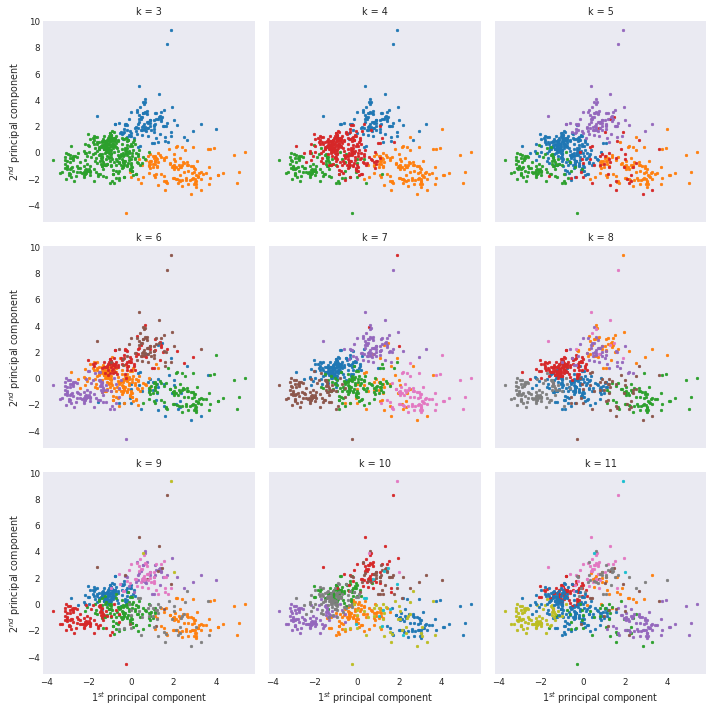

In [344]:
fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for k, ax in enumerate(axes.flat, start=3):
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X_pca)
    for label in range(k):
        indices = labels==label
        _X_pca = X_pca_clip[indices]
        ax.scatter(_X_pca.loc[:,1], _X_pca.loc[:,2],
                   c=f"C{label}", label=name, marker='.')
    ax.set_title(f'k = {k}')
    
for i in range(3):
    axes[2,i].set_xlabel('$1^{st}$ principal component')
    axes[i,0].set_ylabel('$2^{nd}$ principal component')
    
plt.tight_layout()

## Intra cluster variance analysis

In [350]:
max_k = 15
range_k = np.arange(2, max_k+1)
var = []
for k in range_k:
    km = KMeans(k)
    km.fit(X_num_sc)
    var.append(km.inertia_)
var = np.asarray(var)

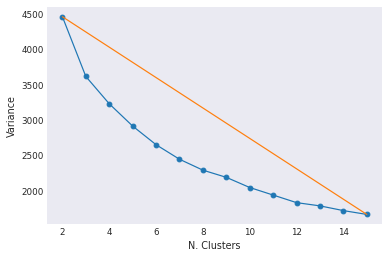

In [351]:
plt.xlabel('N. Clusters')
plt.ylabel('Variance')
plt.plot(range_k, var, marker='o')
plt.plot(range_k[[0,-1]], var[[0,-1]])

In [352]:
def elbow_distance(x, y=None):
    if y is not None:
        p = np.stack([x, y], 1)
    else:
        p = np.asarray(x)
    ri = p[0]
    rf = p[-1]
    dist = np.abs(np.cross(p-ri,p-rf)/np.linalg.norm(p-ri))
    return dist

dists = elbow_distance(range_k, var)

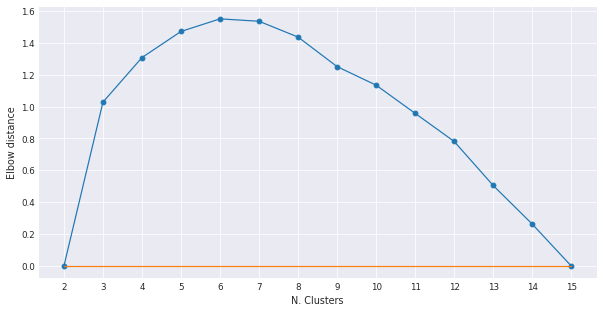

In [354]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(range_k, dists, marker='o')
ax.set_xticks(range_k)
ax.plot(range_k[[0, -1]], [0,0])
ax.set_xlabel('N. Clusters')
ax.set_ylabel('Elbow distance')
ax.grid()

In [355]:
def elbow_analysis(model, X, k_min=2, k_max=15, return_best=False):
    range_k = np.arange(k_min, k_max+1)
    var = np.empty(range_k.shape)
    for i, k in enumerate(range_k):
        var[i] = model(k).fit(X).inertia_
    dist = elbow_distance(range_k, var)
    
     
    fig, axes = plt.subplots(1,2, figsize=(14,4))
    axes[0].set_title(r'Intra-cluster variance $\times$ N. clusters')
    axes[0].set_ylabel('Variance')
    axes[0].plot(range_k, var, marker='o')
    axes[0].plot(range_k[[0,-1]], var[[0,-1]])
    axes[1].set_title(r'Distance $\times$ N. Clusters')
    axes[1].set_ylabel('Elbow distance')
    axes[1].plot(range_k, dist, marker='o')
    axes[1].plot(range_k[[0, -1]], [0,0])
    
    for ax in axes:
        ax.set_xlabel('N. Clusters')
        ax.set_xticks(range_k)
        ax.grid() 
        
    if return_best:
        best_idx = np.argsort(dist)[::-1]
        best = range_k[best_idx[:return_best]]
        return best

### Original dataset

array([7, 8, 9, 6])

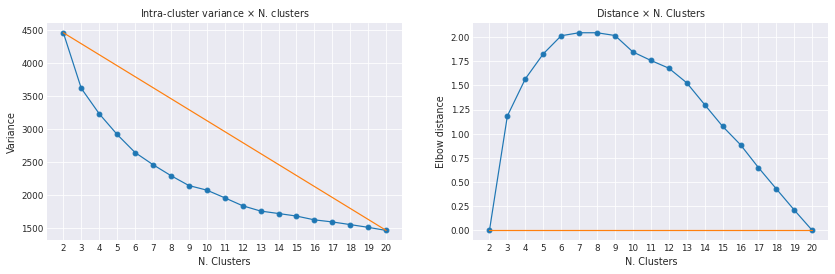

In [359]:
elbow_analysis(KMeans, X_num_sc, k_min=2, k_max=20, return_best=4)

## PCA domain

array([7, 8, 6, 5])

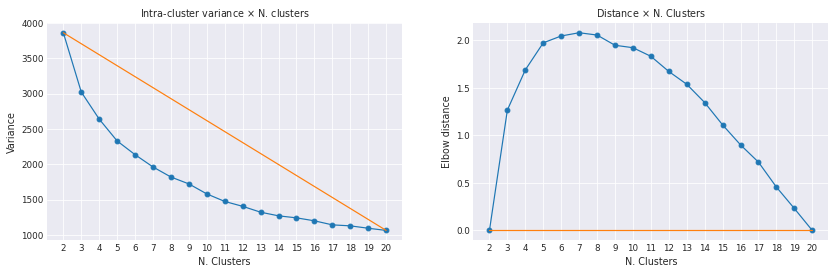

In [365]:
elbow_analysis(KMeans, X_pca, k_min=2, k_max=20, return_best=4)

Best results when k equals:
- 5
- 6
- 7
- 8

## Silhouette Analysis

In [366]:
def view_cluster_silhouettes(model, X, k_min=2, k_max=5, cols=3):
    range_k = np.arange(k_min, k_max+1)
    
    plots = range_k.size
    rows = int(np.ceil(plots/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols,4*rows),
                             sharex=True, squeeze=False)
    for i, k in enumerate(range_k):
        ax = axes.flat[i]
        ax.set_title(f'{k} clusters')
        classes = np.arange(k)
        labels = model(k).fit_predict(X)
        sil = silhouette_samples(X, labels)
        
        mean_sil = sil.mean()
        ax.axvline(mean_sil, c='black', lw=3, alpha=.5,
                   label=f"mean: {mean_sil:.1%}")
         
        pos = np.zeros(2)
        for c in classes:
            sil_c = np.sort(sil[labels==c])
            pos[:] = pos[1], pos[1]+sil_c.size
            ax.barh(np.arange(*pos), sil_c, height=1);
            ax.text(-.05, pos.mean(), str(c))
            
    fig.suptitle('Cluster Silhouettes')
    for ax in axes.flat:
        ax.set_xlabel('Silhouette')
        ax.set_ylabel('Cluster samples')
        ax.set_yticks([])
        ax.legend()
    rm_cols = rows*cols - plots
    for ax in axes[-1, cols-rm_cols:]:
        ax.remove()

No handles with labels found to put in legend.


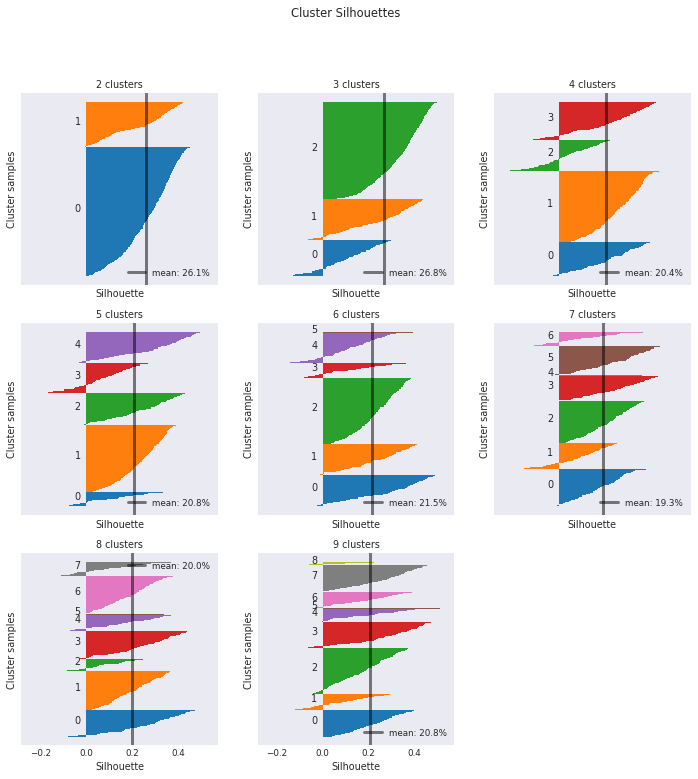

In [367]:
view_cluster_silhouettes(KMeans, X_num_sc, 2, 9)

In [372]:
def silhouette(model, X, k_min=2, k_max=5):
    range_k = np.arange(k_min, k_max+1)
    silhouettes = np.empty(range_k.shape)
    for i, k in enumerate(range_k):
        classes = np.arange(k)
        labels = model(k).fit_predict(X)
        silhouettes[i] = silhouette_samples(X, labels).mean()
    return silhouettes
            
    
def plot_silhouette(model, X, k_min=2, k_max=5, samples=5,
                    fig=None, ax=None):
    if ax is None:
        if fig is None:
            fig = plt.figure(figsize=(8,4))
        ax = fig.add_subplot()
        
    range_k = np.arange(k_min, k_max+1)
    
    sils = [silhouette(KMeans, X, k_min, k_max)
            for _ in range(samples)]
    sils = np.stack(sils, axis=1)
    sils_mean = sils.mean(axis=1)
    sils_std = sils.std(axis=1)
    
    ax.errorbar(range_k, sils_mean, sils_std, marker='o')
    ax.set_title(r'Silhouette $\times$ N. clusters')
    ax.set_xlabel('N. clusters')
    ax.set_ylabel('Silhouette')
    ax.set_xticks(range_k)
    ax.grid()

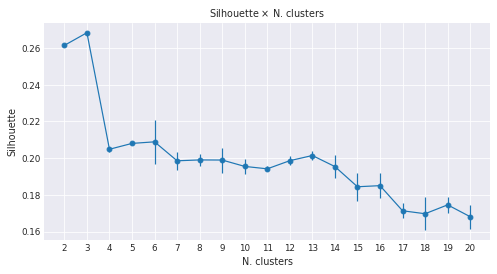

In [373]:
plot_silhouette(KMeans, X_num_sc, 2, 20)

Best results:
- 3
- 5

### Results

In [393]:
ks = [3,4,5,6,7,8,9]
labels = []
label_names = []
for k in ks:
    km = KMeans(k)
    km.fit(X_num_sc)
    labels.append(km.predict(X_num_sc))
    label_names.append(ABC[:k])

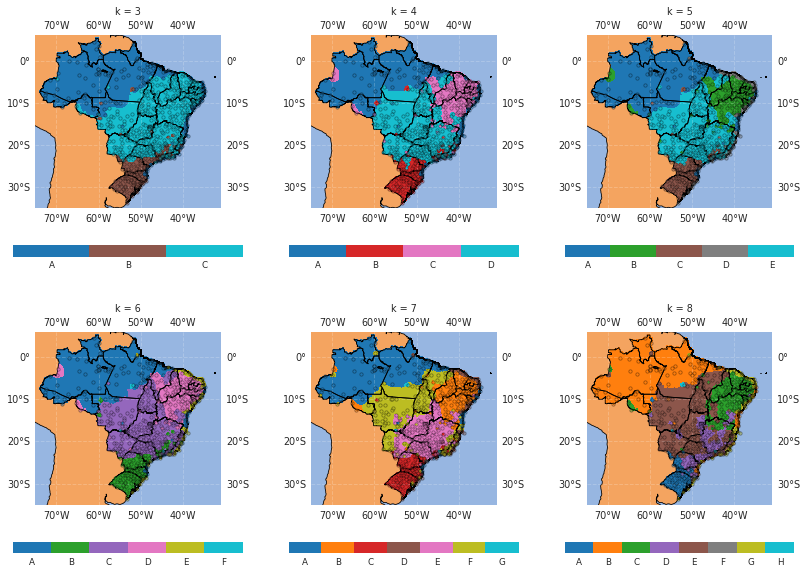

In [394]:
fig, axes = plt.subplots(2,3, figsize=(14,10), subplot_kw={'projection':projection})

for i, ax in enumerate(axes.flat):
    k = ks[i]
    knn_map(coords, labels[i], extents, k=6,
            title=f'k = {k}', ax=axes.flat[i],
            cmap='tab10', label_names=label_names[i],)
# axes.flat[-1].remove()

In [391]:
ks = [3,5,6,7]
labels = []
label_names = []
for k in ks:
    labels.append(KMeans(k).fit_predict(X_num_sc))
    label_names.append(ABC[:k])

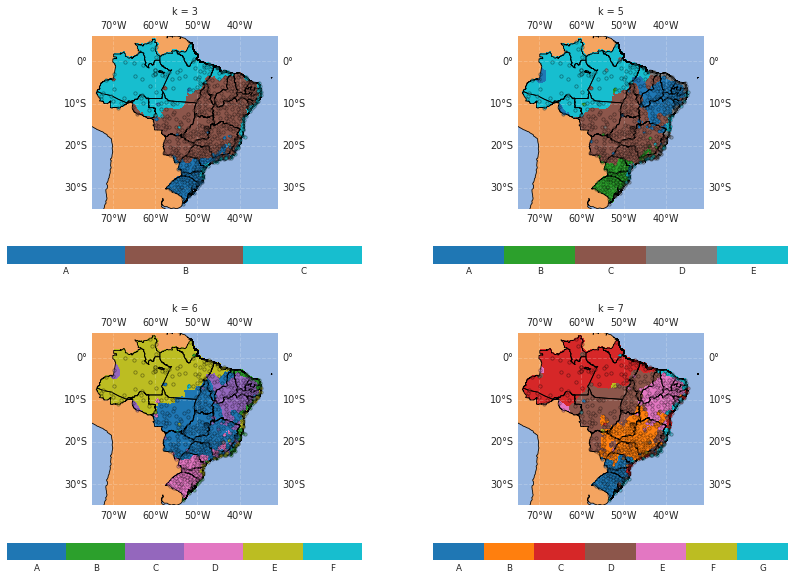

In [392]:
fig, axes = plt.subplots(2,2, figsize=(14,10), subplot_kw={'projection': projection})

for i, ax in enumerate(axes.flat):
    k = ks[i]
    knn_map(coords, labels[i], extents, k=6,
            title=f'k = {k}', ax=axes.flat[i],
            cmap='tab10', label_names=label_names[i],)
# axes.flat[-1].remove()

In [385]:
ks = [3,5,6,7]
labels = []
label_names = []
for k in ks:
    labels.append(KMeans(k).fit_predict(X_pca))
    label_names.append(ABC[:k])

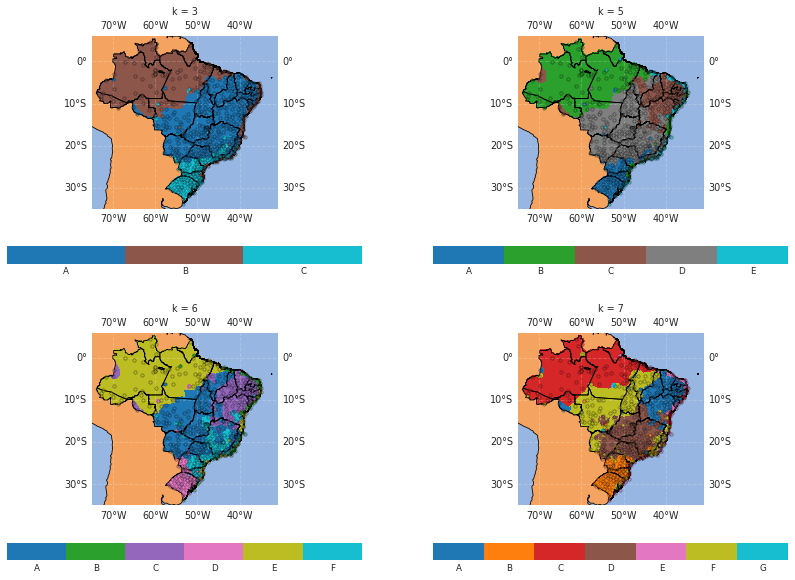

In [387]:
fig, axes = plt.subplots(2,2, figsize=(14,10), subplot_kw={'projection':projection})

for i, ax in enumerate(axes.flat):
    k = ks[i]
    knn_map(coords, labels[i], extents, k=6,
            title=f'k = {k}', ax=axes.flat[i],
            cmap='tab10', label_names=label_names[i],)
# axes.flat[-1].remove()

## Cluster characteristics

,H,P,R,T,V,sH,sP,sR,sT,sV
label,,,,,,,,,,
A,78.891126,999.590892,134.563488,25.463026,1.719062,12.176276,2.112124,80.629794,2.831345,1.050928
B,67.537362,963.058806,80.268068,24.651777,1.932012,16.858695,2.087286,53.624506,3.985026,1.217610
C,77.397061,941.552781,127.745576,18.916850,2.482565,15.546690,3.444962,79.587885,4.067444,1.480972


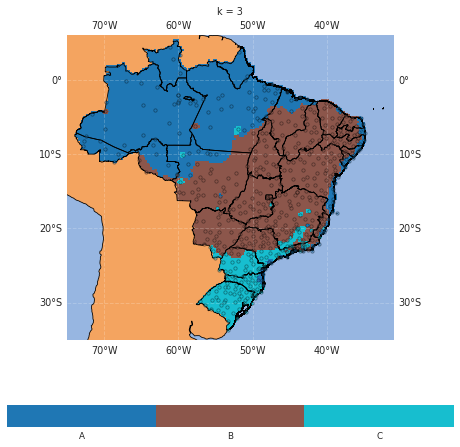

In [449]:
k = 3
kmdf = df.copy()
kmdf['label'] = KMeans(k).fit_predict(X_num_sc)
knn_map(coords, kmdf['label'], extents, k=6,
        title=f'k = {k}', cmap='tab10', label_names=ABC[:k],)
kmdf['label'] = kmdf['label'].apply(lambda i: ABC[i])
table = kmdf.groupby('label').mean()[num_cols]
table

,H,P,R,T,V,sH,sP,sR,sT,sV
label,,,,,,,,,,
A,77.715237,936.752694,131.557258,18.568221,2.437214,15.778291,3.504361,81.140906,4.187205,1.441790
B,62.843136,973.805697,47.044211,26.302958,2.353962,16.386361,1.903479,39.708409,3.711818,1.306529
C,79.260399,998.290966,150.021912,25.519541,1.286348,12.471095,2.111841,86.898189,2.953779,0.917065
D,69.910244,955.436805,98.033751,23.691279,1.677611,17.076527,2.192721,61.138962,4.133665,1.165710
E,77.750806,1004.947945,87.657846,24.114372,3.372434,11.739555,2.525400,62.867451,2.565787,1.649047


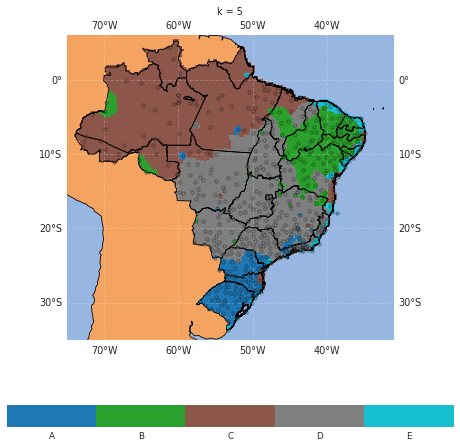

In [482]:
k = 5
label_names = ABC[:k]
kmdf = df.copy()
kmdf['label'] = KMeans(k).fit_predict(X_num_sc)
knn_map(coords, kmdf['label'], extents, k=6,
        title=f'k = {k}', cmap='tab10', label_names=label_names)
kmdf['label'] = kmdf['label'].apply(lambda i: ABC[i])
table = kmdf.groupby('label').mean()[num_cols]
table

## Schematic variable maps

In [504]:
sdf = kmdf[num_cols+['label']].copy()

knn = KNeighborsClassifier(5)
X = coords
y = sdf['label']
knn.fit(X,y)

ŷ = knn.predict(X)
sdf['label'] = ŷ

for c in num_cols:
    for l in label_names:
        sdf.loc[sdf['label']==l, c] = table.loc[l,c]

In [505]:
variables = ['T', 'H', 'P', 'R', 'V']
stds = ['s' + c for c in variables]

T, H, P, R, V = [sdf[[c for c in sdf.columns if c.startswith(var)]].mean(axis=1)
                 for var in variables]
sT, sH, sP, sR, sV = [sdf[[c for c in sdf.columns if c.startswith(var)]].mean(axis=1)
                      for var in stds]

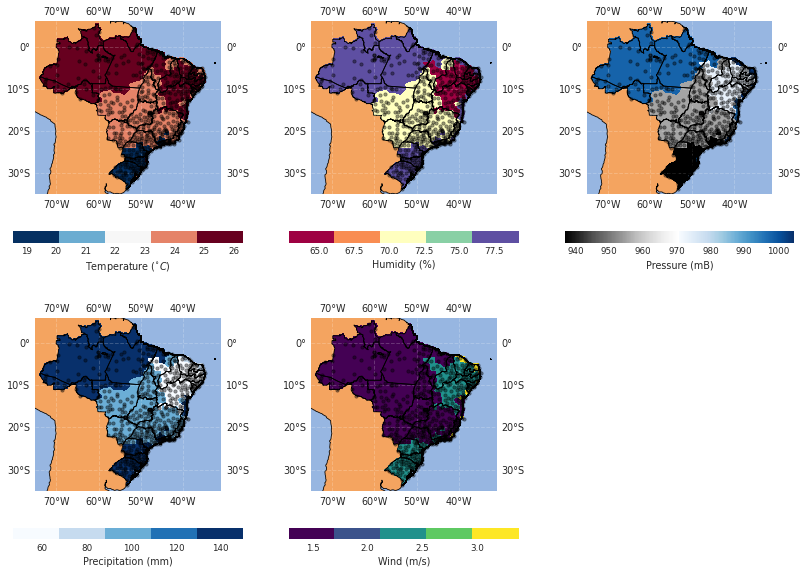

In [513]:
fig, axes = plt.subplots(2, 3, figsize=(14,10), subplot_kw={'projection':projection})

knn_map(coords, T, extents, k=1, n_cmap=5, ax=axes.flat[0], cbar_label=r'Temperature ($^{\circ}C$)', cmap='RdBu_r')
knn_map(coords, H, extents, k=1, n_cmap=5, ax=axes.flat[1], cbar_label=r'Humidity (%)', cmap='Spectral')
knn_map(coords, P, extents, k=1, n_cmap=5, ax=axes.flat[2], cbar_label=r'Pressure (mB)', cmap=grey_blue)
knn_map(coords, R, extents, k=1, n_cmap=5, ax=axes.flat[3], cbar_label=r'Precipitation (mm)', cmap='Blues')
knn_map(coords, V, extents, k=1, n_cmap=5, ax=axes.flat[4], cbar_label=r'Wind (m/s)', cmap='viridis')
axes.flat[-1].remove()

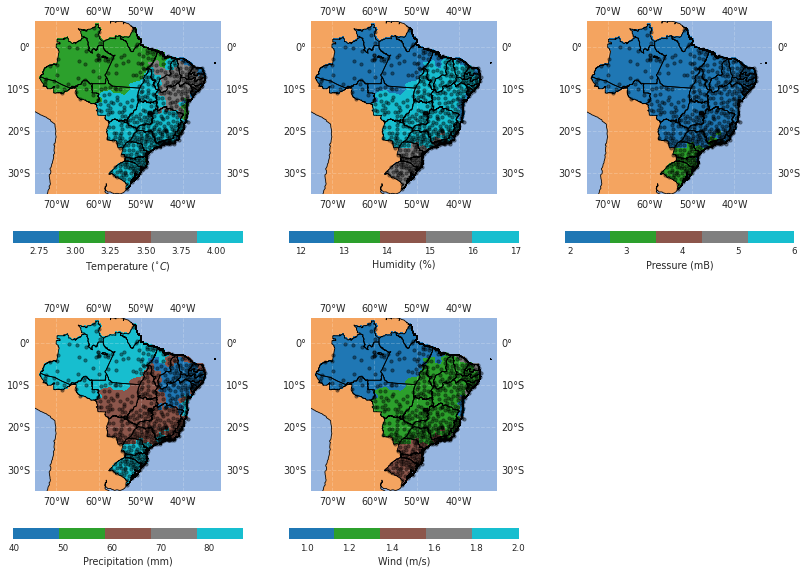

In [509]:
fig, axes = plt.subplots(2,3, figsize=(14,10), subplot_kw={'projection':projection})
scmap = 'tab10'
knn_map(coords, sT, extents, k=1, n_cmap=5, ax=axes.flat[0], cbar_label=r'Temperature ($^{\circ}C$)', cmap=scmap)
knn_map(coords, sH, extents, k=1, n_cmap=5, ax=axes.flat[1], cbar_label=r'Humidity (%)', cmap=scmap)
knn_map(coords, sP, extents, k=1, n_cmap=5, ax=axes.flat[2], cbar_label=r'Pressure (mB)', cmap=scmap, vmax=6)
knn_map(coords, sR, extents, k=1, n_cmap=5, ax=axes.flat[3], cbar_label=r'Precipitation (mm)', cmap=scmap)
knn_map(coords, sV, extents, k=1, n_cmap=5, ax=axes.flat[4], cbar_label=r'Wind (m/s)', cmap=scmap, vmax=2)
axes.flat[-1].remove()

## Misc. - Using categoric variables

In [404]:
X_all = df[coord_cols+cat_cols+pca_cols]
X_all.head()

,lon,lat,NE,N,CO,S,SE,1,2,3,4,5
0,-47.925833,-15.789444,1,0,0,0,0,-0.847106,0.981557,-0.052871,-1.698452,0.598127
1,-48.131111,-15.599722,1,0,0,0,0,-0.873402,0.710085,0.442283,-1.934483,0.516722
2,-50.141389,-15.939167,0,0,0,0,1,-0.673966,-0.644175,-1.163536,-0.506441,-0.688486
3,-60.016389,-3.103333,0,0,0,1,0,2.021792,-1.957614,-0.381864,0.140697,-0.009066
4,-69.866944,-6.650278,0,0,0,1,0,2.036194,-1.260124,-1.246281,0.146786,-0.392069


No handles with labels found to put in legend.


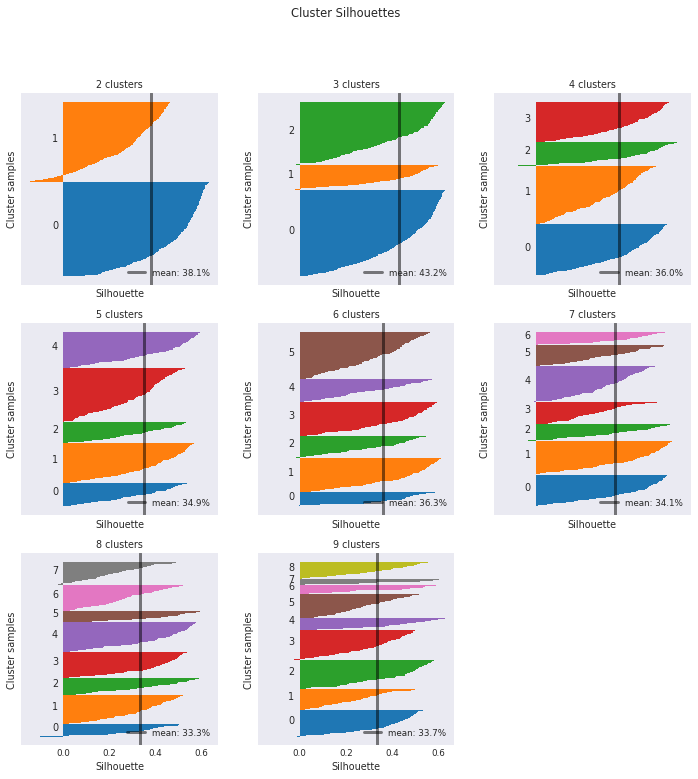

In [414]:
view_cluster_silhouettes(KMeans, X_all, 2, 9)

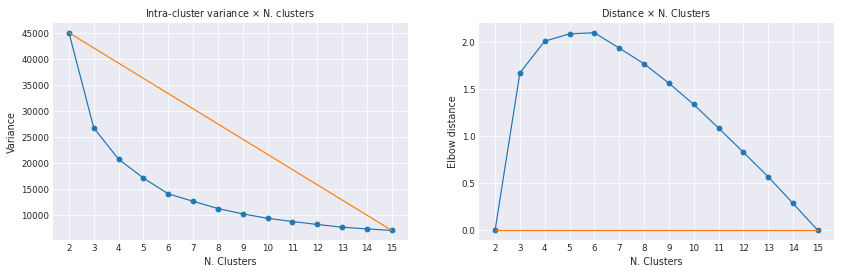

In [417]:
elbow_analysis(KMeans, X_all, k_max=15)

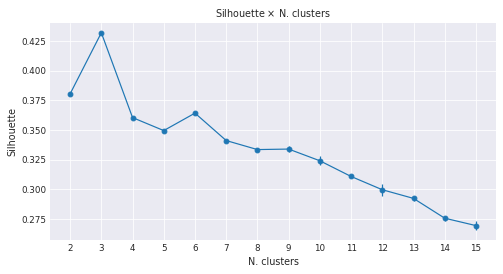

In [416]:
plot_silhouette(KMeans, X_all, k_max=15)

In [418]:
range_k = [3,5,6,7]
labels = []
label_names = []
for k in range_k:
    labels.append(KMeans(k).fit_predict(X_all))
    label_names.append(ABC[:k])

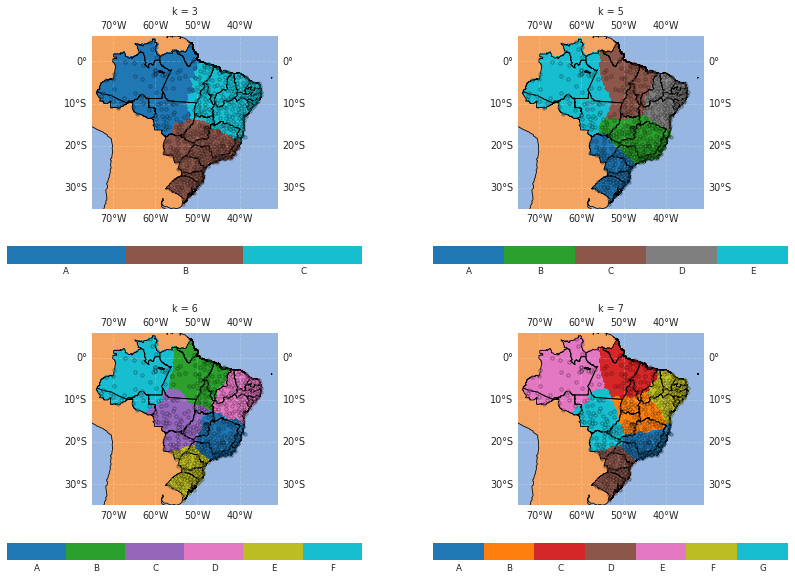

In [419]:
fig, axes = plt.subplots(2,2, figsize=(14,10), subplot_kw={'projection':projection})

for i, ax in enumerate(axes.flat):
    k = range_k[i]
    knn_map(coords, labels[i], extents, k=6,
            title=f'k = {k}', ax=axes.flat[i],
            cmap='tab10', label_names=label_names[i],)